# Modules

In [7]:
import seaborn as sns
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
from sklearn.metrics import mean_squared_error

# Data

In [15]:
# Get forex historical Data
df = yf.download(tickers='AAPL',
                 period='2000d',
                 interval='1d')

df = df.drop(['High','Open','Low','Volume', 'Adj Close'], axis=1)
df = df.reset_index()
df.head(10)

[*********************100%***********************]  1 of 1 completed


,Date,Close
0,2016-08-08,27.092501
1,2016-08-09,27.202499
2,2016-08-10,27.000000
3,2016-08-11,26.982500
4,2016-08-12,27.045000
5,2016-08-15,27.370001
6,2016-08-16,27.344999
7,2016-08-17,27.305000
8,2016-08-18,27.270000
9,2016-08-19,27.340000


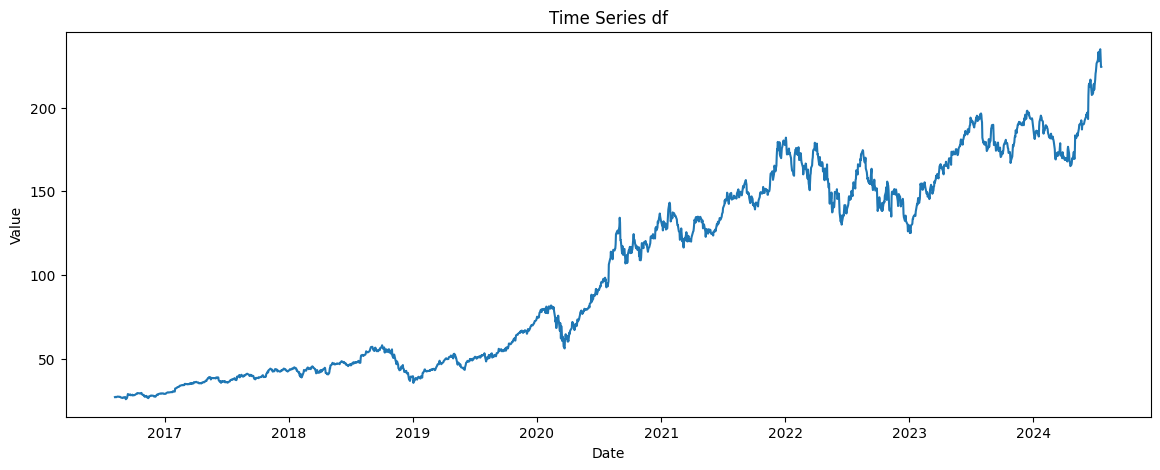

In [16]:
# Plot the time series df
plt.figure(figsize=(14,5))
plt.plot(df['Date'], df['Close'])
plt.title('Time Series df')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

In [17]:
# Set the date column as index if it's not already
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Normalize the df
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

# Convert the scaled df back to a dfframe
df_scaled = pd.DataFrame(df_scaled, index=df.index, columns=df.columns)
df_scaled = df_scaled.reset_index()
df_scaled

,Date,Close
0,2016-08-08,0.006267
1,2016-08-09,0.006793
2,2016-08-10,0.005824
3,2016-08-11,0.005741
4,2016-08-12,0.006040
...,...,...
1995,2024-07-15,0.997991
1996,2024-07-16,1.000000
1997,2024-07-17,0.971584
1998,2024-07-18,0.949100


In [36]:
# Split the data into training and test sets (80-20 split)
train_size = int(len(df_scaled) * 0.8)
test_size = len(df_scaled) - train_size
train, test = df_scaled[0:train_size], df_scaled[train_size:len(df_scaled)]

# Function to create dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step)]
        dataX.append(a)
        dataY.append(dataset[i + time_step])
    return np.array(dataX), np.array(dataY)

# Reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 10
X_train, y_train = create_dataset(train["Close"].values, time_step)
X_test, y_test = create_dataset(test["Close"].values, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Model

In [37]:
# Vanilla LSTM Model
model_vanilla = Sequential()
model_vanilla.add(LSTM(50, return_sequences=False, input_shape=(time_step, 1)))
model_vanilla.add(Dense(1))
model_vanilla.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model_vanilla.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=1)

# Make predictions
train_predict_vanilla = model_vanilla.predict(X_train)
test_predict_vanilla = model_vanilla.predict(X_test)

# Invert predictions
train_predict_vanilla = scaler.inverse_transform(train_predict_vanilla)
test_predict_vanilla = scaler.inverse_transform(test_predict_vanilla)

# Calculate RMSE
rmse_vanilla = np.sqrt(mean_squared_error(y_test, test_predict_vanilla))
print(f'Vanilla LSTM RMSE: {rmse_vanilla}')


Epoch 1/50
25/25 [==============================] - 6s 66ms/step - loss: 0.0500 - val_loss: 0.0012
Epoch 2/50
25/25 [==============================] - 0s 17ms/step - loss: 0.0044 - val_loss: 0.0021
Epoch 3/50
25/25 [==============================] - 1s 23ms/step - loss: 5.9886e-04 - val_loss: 6.1236e-04
Epoch 4/50
25/25 [==============================] - 1s 23ms/step - loss: 3.4157e-04 - val_loss: 5.7154e-04
Epoch 5/50
25/25 [==============================] - 1s 21ms/step - loss: 3.1641e-04 - val_loss: 5.7482e-04
Epoch 6/50
25/25 [==============================] - 0s 17ms/step - loss: 3.1254e-04 - val_loss: 5.8080e-04
Epoch 7/50
25/25 [==============================] - 0s 17ms/step - loss: 3.0697e-04 - val_loss: 5.8485e-04
Epoch 8/50
25/25 [==============================] - 0s 18ms/step - loss: 2.9479e-04 - val_loss: 5.6742e-04
Epoch 9/50
25/25 [==============================] - 0s 18ms/step - loss: 2.9950e-04 - val_loss: 5.5407e-04
Epoch 10/50
25/25 [==============================] - 

In [38]:
# Stacked LSTM Model
model_stacked = Sequential()
model_stacked.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model_stacked.add(LSTM(50, return_sequences=False))
model_stacked.add(Dense(1))
model_stacked.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model_stacked.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=1)

# Make predictions
train_predict_stacked = model_stacked.predict(X_train)
test_predict_stacked = model_stacked.predict(X_test)

# Invert predictions
train_predict_stacked = scaler.inverse_transform(train_predict_stacked)
test_predict_stacked = scaler.inverse_transform(test_predict_stacked)

# Calculate RMSE
rmse_stacked = np.sqrt(mean_squared_error(y_test, test_predict_stacked))
print(f'Stacked LSTM RMSE: {rmse_stacked}')


Epoch 1/50
25/25 [==============================] - 11s 106ms/step - loss: 0.0285 - val_loss: 0.0305
Epoch 2/50
25/25 [==============================] - 1s 44ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 3/50
25/25 [==============================] - 1s 35ms/step - loss: 4.7007e-04 - val_loss: 8.0482e-04
Epoch 4/50
25/25 [==============================] - 1s 38ms/step - loss: 3.7035e-04 - val_loss: 6.5756e-04
Epoch 5/50
25/25 [==============================] - 1s 32ms/step - loss: 3.4322e-04 - val_loss: 9.0720e-04
Epoch 6/50
25/25 [==============================] - 1s 31ms/step - loss: 3.4002e-04 - val_loss: 6.9223e-04
Epoch 7/50
25/25 [==============================] - 1s 35ms/step - loss: 3.3688e-04 - val_loss: 7.4820e-04
Epoch 8/50
25/25 [==============================] - 1s 40ms/step - loss: 3.2708e-04 - val_loss: 8.3984e-04
Epoch 9/50
25/25 [==============================] - 1s 58ms/step - loss: 3.2763e-04 - val_loss: 7.7994e-04
Epoch 10/50
25/25 [==============================] 

In [39]:
# Bidirectional LSTM Model
model_bidirectional = Sequential()
model_bidirectional.add(Bidirectional(LSTM(50, return_sequences=False), input_shape=(time_step, 1)))
model_bidirectional.add(Dense(1))
model_bidirectional.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model_bidirectional.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=1)

# Make predictions
train_predict_bidirectional = model_bidirectional.predict(X_train)
test_predict_bidirectional = model_bidirectional.predict(X_test)

# Invert predictions
train_predict_bidirectional = scaler.inverse_transform(train_predict_bidirectional)
test_predict_bidirectional = scaler.inverse_transform(test_predict_bidirectional)

# Calculate RMSE
rmse_bidirectional = np.sqrt(mean_squared_error(y_test, test_predict_bidirectional))
print(f'Bidirectional LSTM RMSE: {rmse_bidirectional}')


Epoch 1/50
25/25 [==============================] - 10s 101ms/step - loss: 0.0314 - val_loss: 0.0055
Epoch 2/50
25/25 [==============================] - 1s 22ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 3/50
25/25 [==============================] - 1s 21ms/step - loss: 4.0393e-04 - val_loss: 9.2960e-04
Epoch 4/50
25/25 [==============================] - 1s 21ms/step - loss: 3.4317e-04 - val_loss: 5.9933e-04
Epoch 5/50
25/25 [==============================] - 1s 21ms/step - loss: 3.2323e-04 - val_loss: 6.0567e-04
Epoch 6/50
25/25 [==============================] - 1s 27ms/step - loss: 3.3771e-04 - val_loss: 5.9837e-04
Epoch 7/50
25/25 [==============================] - 1s 22ms/step - loss: 3.1687e-04 - val_loss: 5.9199e-04
Epoch 8/50
25/25 [==============================] - 1s 33ms/step - loss: 3.0934e-04 - val_loss: 6.2148e-04
Epoch 9/50
25/25 [==============================] - 1s 22ms/step - loss: 3.0777e-04 - val_loss: 5.8160e-04
Epoch 10/50
25/25 [==============================] 

In [40]:
# Stacked Bidirectional LSTM Model
model_stacked_bidirectional = Sequential()
model_stacked_bidirectional.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(time_step, 1)))
model_stacked_bidirectional.add(Bidirectional(LSTM(50, return_sequences=False)))
model_stacked_bidirectional.add(Dense(1))
model_stacked_bidirectional.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model_stacked_bidirectional.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=1)

# Make predictions
train_predict_stacked_bidirectional = model_stacked_bidirectional.predict(X_train)
test_predict_stacked_bidirectional = model_stacked_bidirectional.predict(X_test)

# Invert predictions
train_predict_stacked_bidirectional = scaler.inverse_transform(train_predict_stacked_bidirectional)
test_predict_stacked_bidirectional = scaler.inverse_transform(test_predict_stacked_bidirectional)

# Calculate RMSE
rmse_stacked_bidirectional = np.sqrt(mean_squared_error(y_test, test_predict_stacked_bidirectional))
print(f'Stacked Bidirectional LSTM RMSE: {rmse_stacked_bidirectional}')


Epoch 1/50
25/25 [==============================] - 17s 161ms/step - loss: 0.0174 - val_loss: 0.0078
Epoch 2/50
25/25 [==============================] - 1s 46ms/step - loss: 8.1874e-04 - val_loss: 6.0718e-04
Epoch 3/50
25/25 [==============================] - 1s 46ms/step - loss: 3.6456e-04 - val_loss: 6.2245e-04
Epoch 4/50
25/25 [==============================] - 1s 46ms/step - loss: 2.9978e-04 - val_loss: 7.2976e-04
Epoch 5/50
25/25 [==============================] - 2s 72ms/step - loss: 2.9632e-04 - val_loss: 7.3328e-04
Epoch 6/50
25/25 [==============================] - 2s 65ms/step - loss: 2.9591e-04 - val_loss: 6.6432e-04
Epoch 7/50
25/25 [==============================] - 2s 74ms/step - loss: 2.9528e-04 - val_loss: 7.4755e-04
Epoch 8/50
25/25 [==============================] - 2s 74ms/step - loss: 2.8950e-04 - val_loss: 8.4595e-04
Epoch 9/50
25/25 [==============================] - 2s 67ms/step - loss: 2.8999e-04 - val_loss: 7.4557e-04
Epoch 10/50
25/25 [========================

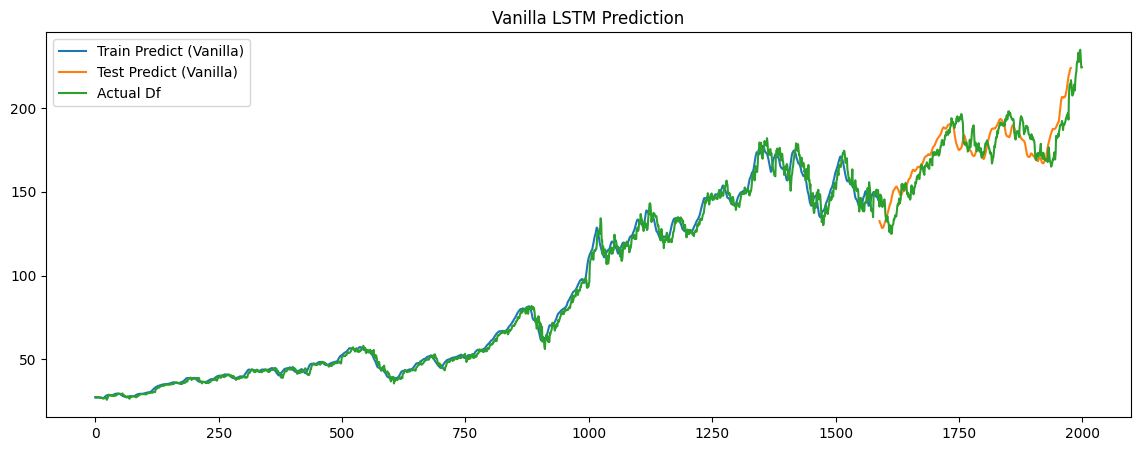

In [43]:
# Plot the results for Vanilla LSTM
plt.figure(figsize=(14,5))
plt.plot(df_scaled.index[:len(train_predict_vanilla)], train_predict_vanilla, label='Train Predict (Vanilla)')
plt.plot(df_scaled.index[len(train_predict_vanilla):len(train_predict_vanilla) + len(test_predict_vanilla)], test_predict_vanilla, label='Test Predict (Vanilla)')
plt.plot(df_scaled.index, df.Close, label='Actual Df')
plt.title('Vanilla LSTM Prediction')
plt.legend()
plt.show()

# Repeat similar plotting for other models by replacing the predicted variables

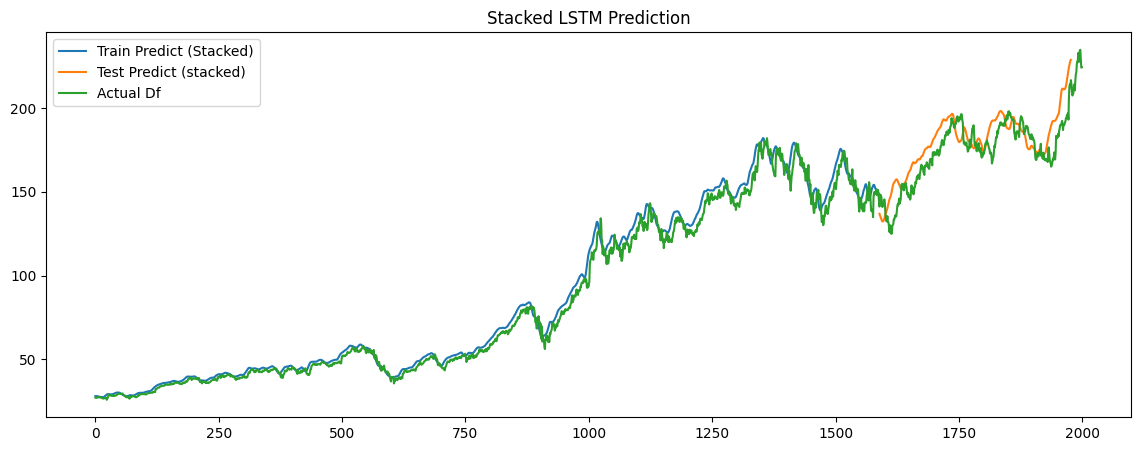

In [44]:
# Plot the results for stacked LSTM
plt.figure(figsize=(14,5))
plt.plot(df_scaled.index[:len(train_predict_stacked)], train_predict_stacked, label='Train Predict (Stacked)')
plt.plot(df_scaled.index[len(train_predict_stacked):len(train_predict_stacked) + len(test_predict_stacked)], test_predict_stacked, label='Test Predict (stacked)')
plt.plot(df_scaled.index, df.Close, label='Actual Df')
plt.title('Stacked LSTM Prediction')
plt.legend()
plt.show()

# Repeat similar plotting for other models by replacing the predicted variables

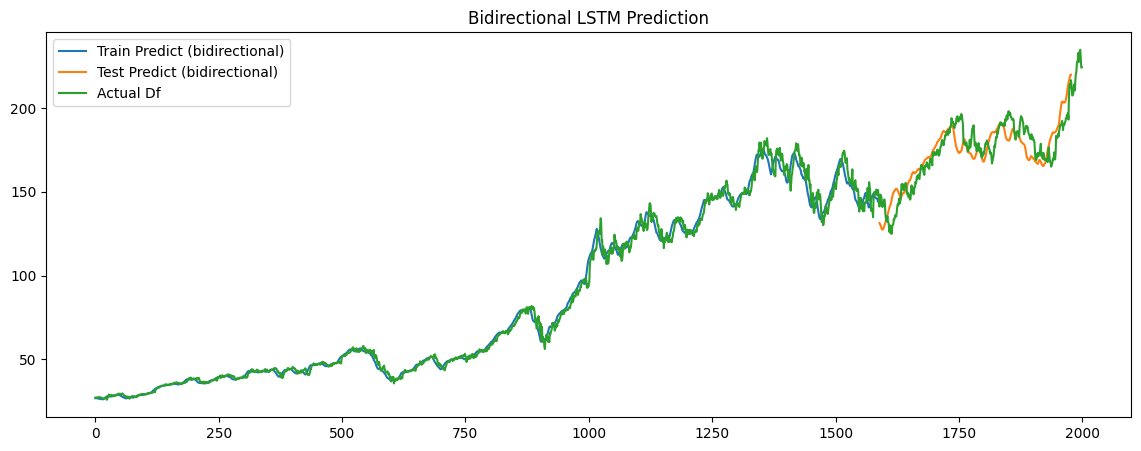

In [45]:
# Plot the results for bidirectional LSTM
plt.figure(figsize=(14,5))
plt.plot(df_scaled.index[:len(train_predict_bidirectional)], train_predict_bidirectional, label='Train Predict (bidirectional)')
plt.plot(df_scaled.index[len(train_predict_bidirectional):len(train_predict_bidirectional) + len(test_predict_bidirectional)], test_predict_bidirectional, label='Test Predict (bidirectional)')
plt.plot(df_scaled.index, df.Close, label='Actual Df')
plt.title('Bidirectional LSTM Prediction')
plt.legend()
plt.show()


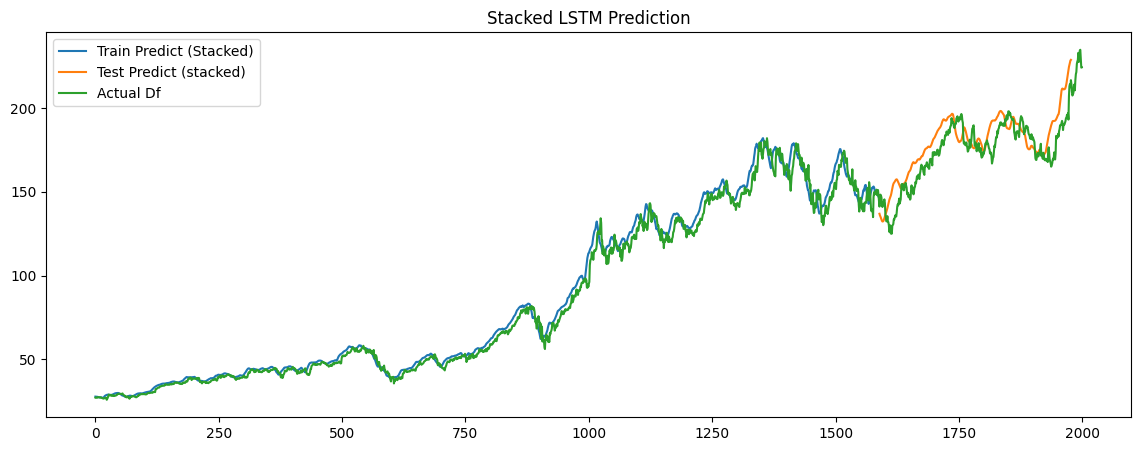

In [46]:
# Plot the results for stacked LSTM
plt.figure(figsize=(14,5))
plt.plot(df_scaled.index[:len(train_predict_stacked_bidirectional)], train_predict_stacked_bidirectional, label='Train Predict (Stacked)')
plt.plot(df_scaled.index[len(train_predict_stacked_bidirectional):len(train_predict_stacked_bidirectional) + len(test_predict_stacked)], test_predict_stacked, label='Test Predict (stacked)')
plt.plot(df_scaled.index, df.Close, label='Actual Df')
plt.title('Stacked LSTM Prediction')
plt.legend()
plt.show()

